In [306]:
import prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,5)


In [307]:
# Reading data
d = pd.read_csv("Revenue_Главная_web_9-19_2024_01_15 (2).csv")
d.head()

,utc_event_date,revenue_main
0,01/01/21,0.0
1,02/01/21,0.0
2,03/01/21,0.0
3,04/01/21,0.0
4,05/01/21,0.0


In [308]:
# Removing no-data period
d = d[d['revenue_main'] != 0]
d.head()

,utc_event_date,revenue_main
67,09/03/21,1.440000e+02
68,10/03/21,2.858725e+06
69,11/03/21,5.511104e+06
70,12/03/21,5.927380e+06
71,13/03/21,5.042469e+06


In [309]:
# Converting to datetime and renaming for Prophet

d["utc_event_date"] = pd.to_datetime(d["utc_event_date"], dayfirst = True)
d = d.rename(columns={"revenue_main": "y", "utc_event_date": "ds"})

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_47942/1858956280.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d["utc_event_date"] = pd.to_datetime(d["utc_event_date"], dayfirst = True)


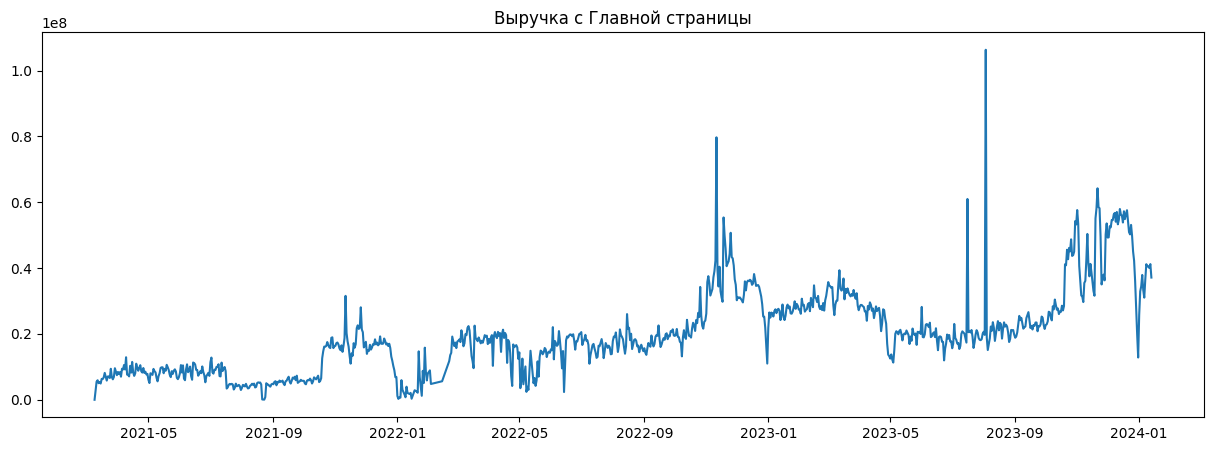

In [310]:
plt.rcParams["figure.figsize"] = (15,5)

plt.figure
plt.plot(d.ds, d.y)
plt.title("Выручка с Главной страницы")
plt.show()

### Слабо Стационарный? - НЕТ

### Сильно Стационарный? - НЕТ

# Seasonal Decomposition

In [311]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (20,10)

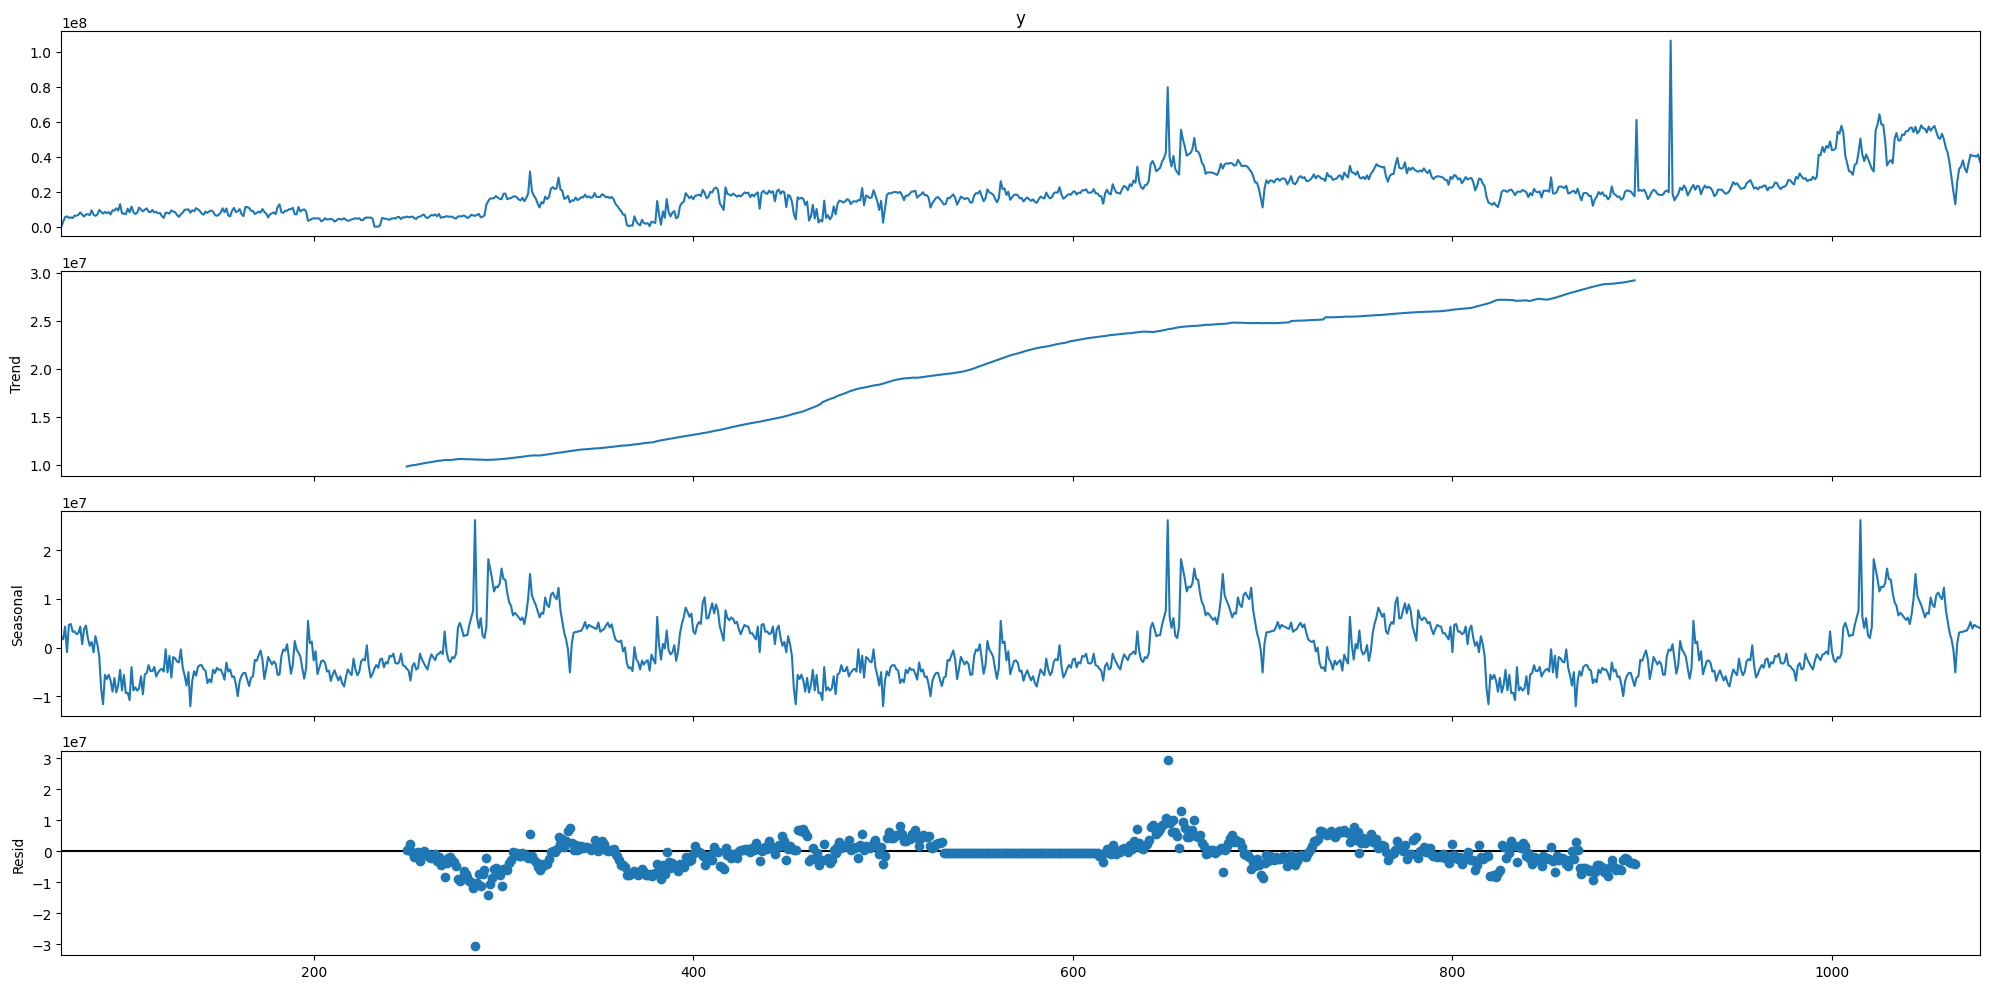

In [312]:
decompose = seasonal_decompose(x = d.y, 
                               period = 365, 
                               model = "additive",
                              )
decompose.plot()
plt.show()

In [313]:
d.index = d.ds

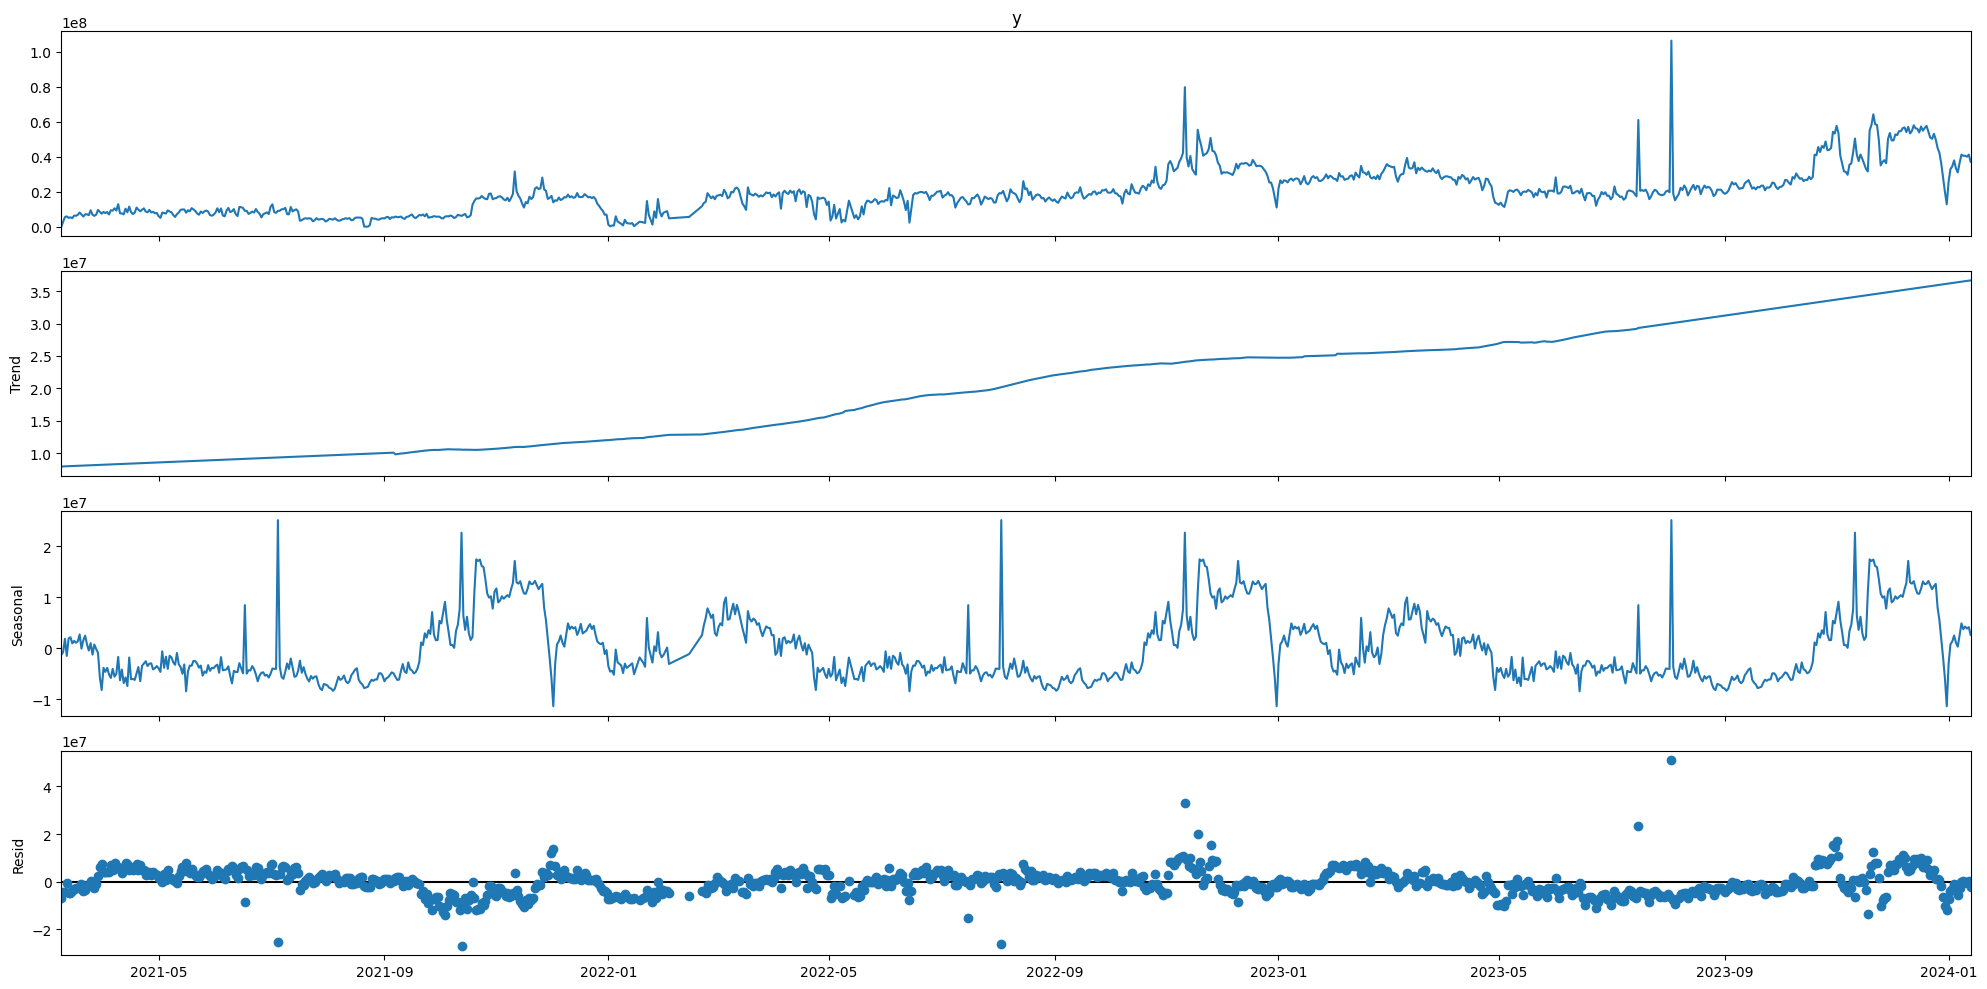

In [314]:
decompose_a = seasonal_decompose(x = d.y, 
                               period = 365, 
                               model = "additive",
                               extrapolate_trend= 60 # closest points to extrapolate
                              )
decompose_a.plot()
plt.show()

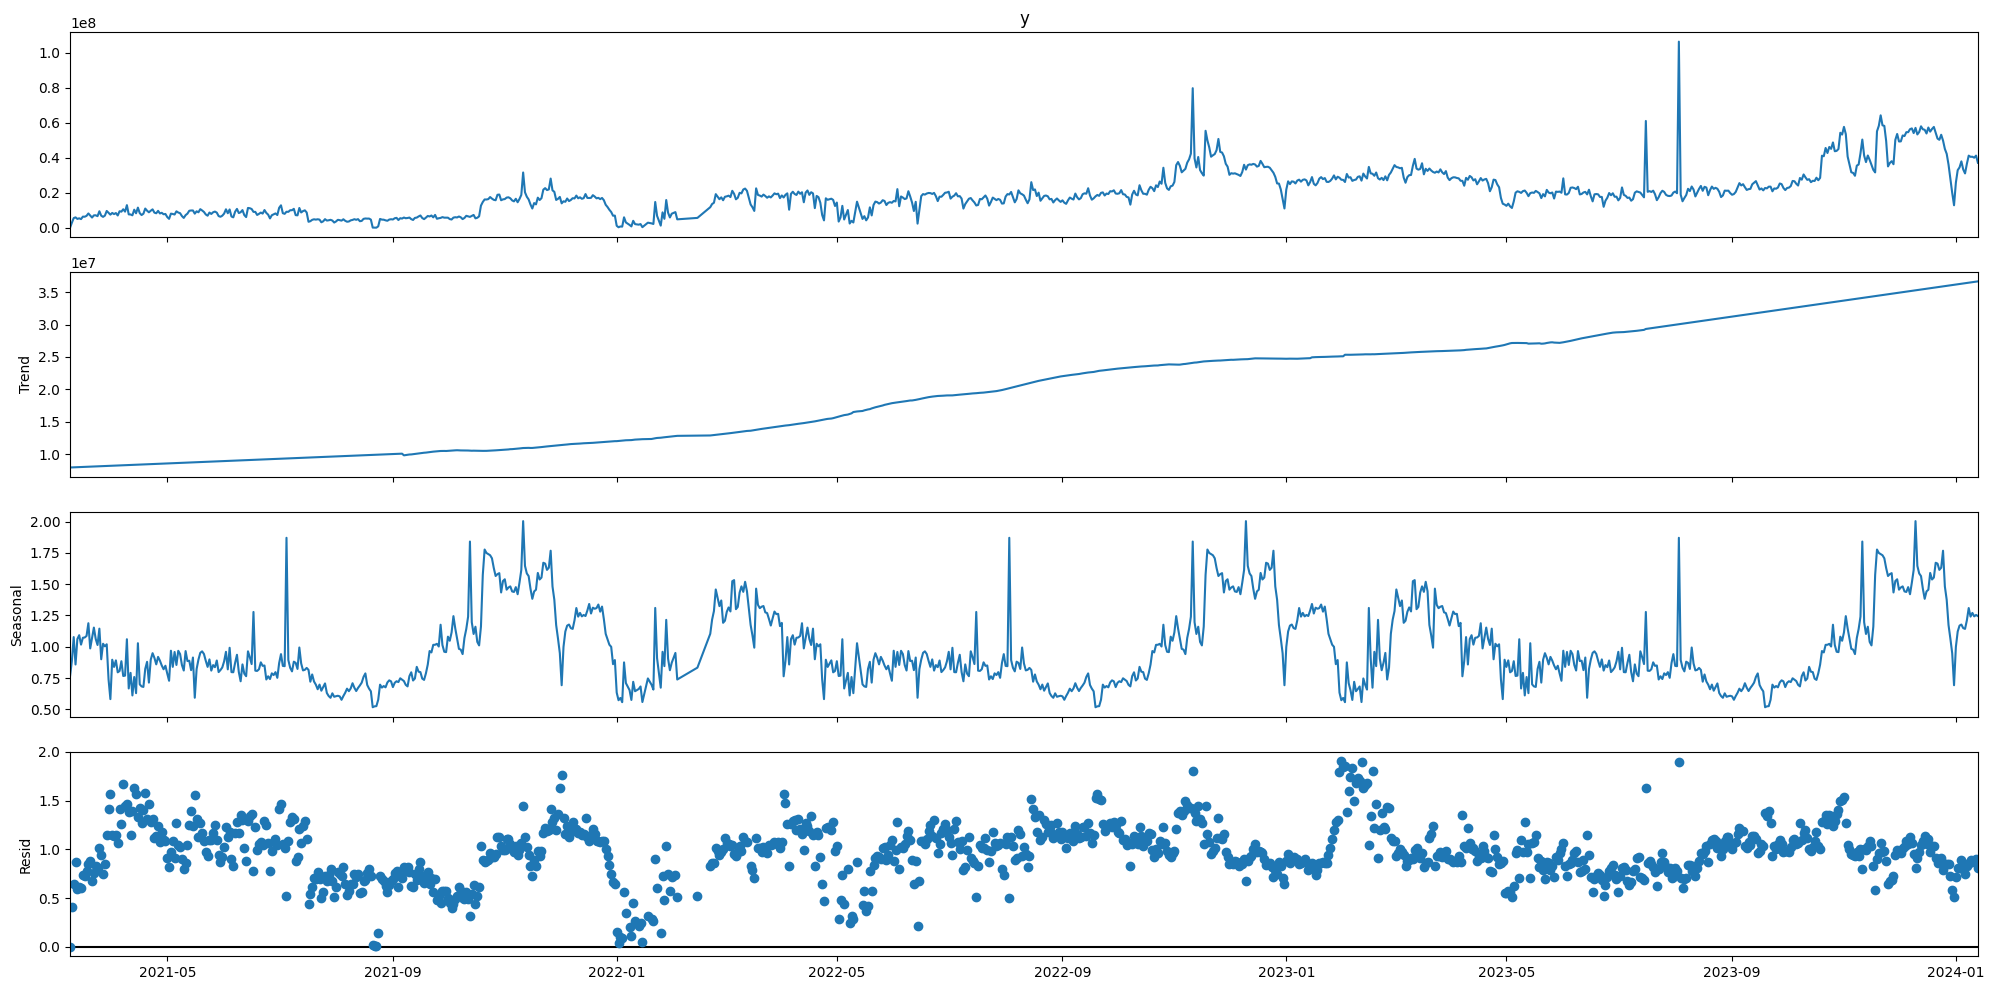

In [315]:
decompose_m = seasonal_decompose(x = d.y, 
                               period = 365, 
                               model = "multiplicative",
                               extrapolate_trend= 60 # closest points to extrapolate
                              )
decompose_m.plot()
plt.show()

In [316]:
forecast = decompose_a.trend + decompose_a.seasonal
d1 = pd.DataFrame(forecast).rename(columns={0: "forecast"})
d1

,forecast
ds,
2021-03-09,6.619191e+06
2021-03-10,7.148532e+06
2021-03-11,9.788276e+06
2021-03-12,6.444784e+06
2021-03-13,9.881967e+06
...,...
2024-01-09,4.021769e+07
2024-01-10,4.077842e+07
2024-01-11,4.042316e+07


In [317]:
d1["observed"] = decompose_a.observed

In [318]:
d1.reset_index(inplace=True)
d1

,ds,forecast,observed
0,2021-03-09,6.619191e+06,1.440000e+02
1,2021-03-10,7.148532e+06,2.858725e+06
2,2021-03-11,9.788276e+06,5.511104e+06
3,2021-03-12,6.444784e+06,5.927380e+06
4,2021-03-13,9.881967e+06,5.042469e+06
...,...,...,...
1007,2024-01-09,4.021769e+07,4.052303e+07
1008,2024-01-10,4.077842e+07,4.055967e+07
1009,2024-01-11,4.042316e+07,4.001305e+07
1010,2024-01-12,4.074444e+07,4.120578e+07


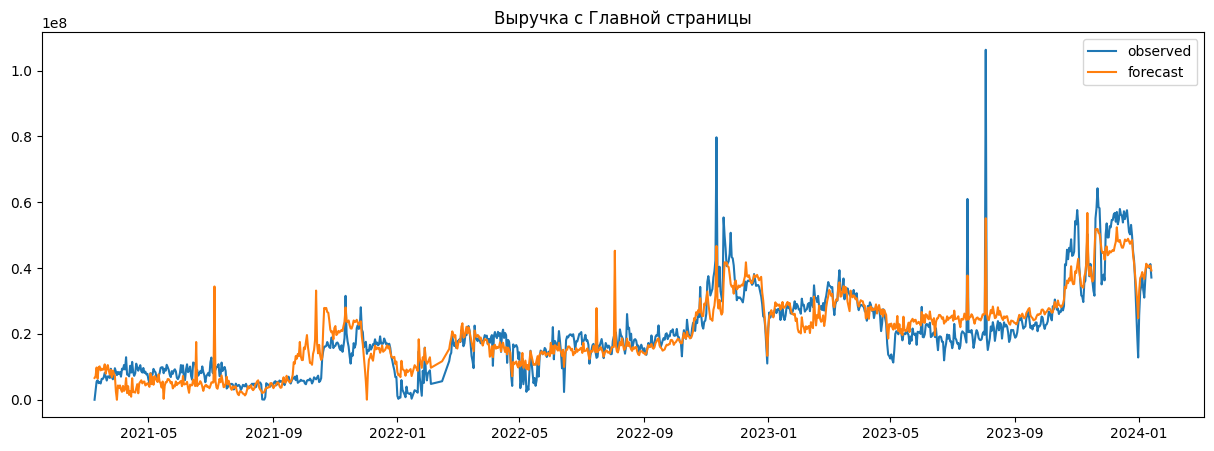

In [319]:
plt.rcParams["figure.figsize"] = (15,5)

plt.figure
plt.plot(d1.ds, d1.observed, label = "observed")
plt.plot(d1.ds, d1.forecast, label = "forecast")
plt.title("Выручка с Главной страницы")
plt.legend()
plt.show()

# Smoothing of Time Series

## Moving Avegage

In [320]:
for period in (3, 7, 14, 30, 60, 90):
    d[f"y_ma_{period}"] = d["y"].rolling(period).mean()
d

,ds,y,y_ma_3,y_ma_7,y_ma_14,y_ma_30,y_ma_60,y_ma_90
ds,,,,,,,,
2021-03-09,2021-03-09,1.440000e+02,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-10,2021-03-10,2.858725e+06,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-11,2021-03-11,5.511104e+06,2.789991e+06,NaN,NaN,NaN,NaN,NaN
2021-03-12,2021-03-12,5.927380e+06,4.765736e+06,NaN,NaN,NaN,NaN,NaN
2021-03-13,2021-03-13,5.042469e+06,5.493651e+06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-01-09,2024-01-09,4.052303e+07,3.941374e+07,3.642507e+07,3.231890e+07,4.379934e+07,4.590904e+07,4.353704e+07
2024-01-10,2024-01-10,4.055967e+07,4.075646e+07,3.729527e+07,3.219961e+07,4.337465e+07,4.574557e+07,4.368375e+07
2024-01-11,2024-01-11,4.001305e+07,4.036525e+07,3.759450e+07,3.248264e+07,4.288593e+07,4.572559e+07,4.382023e+07


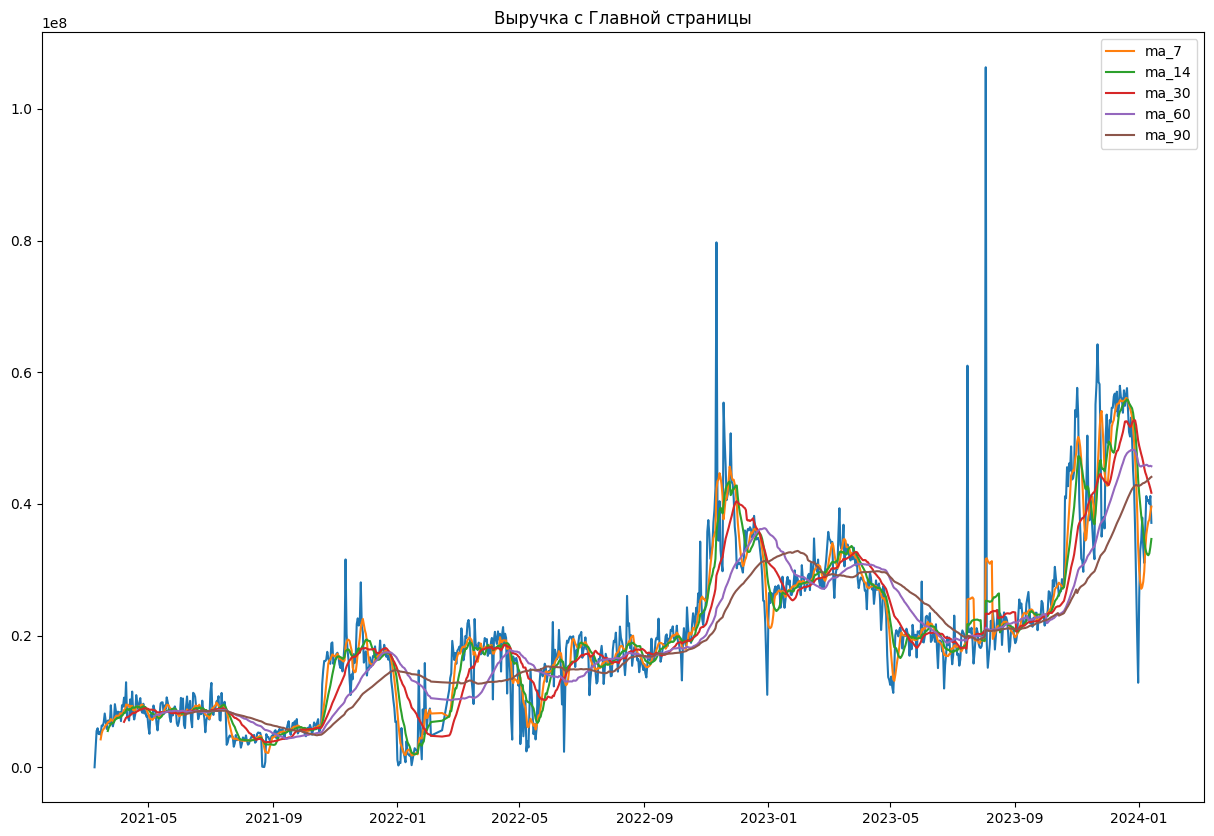

In [321]:
plt.rcParams["figure.figsize"] = (15,10)

plt.figure
plt.plot(d.ds, d.y)
for period in (7, 14, 30, 60, 90):
    plt.plot(d.ds, d[f"y_ma_{period}"], label = f"ma_{period}")
plt.legend()
plt.title("Выручка с Главной страницы")
plt.show()

In [322]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [323]:
for frac in (0.01, 0.05, 0.2, 0.5, 0.7, 1):
    d[f"y_lowess_{frac}"] = lowess(exog = d.ds, endog = d.y, frac = frac)[:,1]
d

,ds,y,y_ma_3,y_ma_7,y_ma_14,y_ma_30,y_ma_60,y_ma_90,y_lowess_0.01,y_lowess_0.05,y_lowess_0.2,y_lowess_0.5,y_lowess_0.7,y_lowess_1
ds,,,,,,,,,,,,,,
2021-03-09,2021-03-09,1.440000e+02,NaN,NaN,NaN,NaN,NaN,NaN,2.092759e+06,4.712581e+06,8.029146e+06,5.663958e+06,5.262009e+06,4.706629e+06
2021-03-10,2021-03-10,2.858725e+06,NaN,NaN,NaN,NaN,NaN,NaN,2.898051e+06,4.868021e+06,8.031561e+06,5.683446e+06,5.285590e+06,4.734135e+06
2021-03-11,2021-03-11,5.511104e+06,2.789991e+06,NaN,NaN,NaN,NaN,NaN,3.646905e+06,5.022103e+06,8.033809e+06,5.702960e+06,5.309179e+06,4.761645e+06
2021-03-12,2021-03-12,5.927380e+06,4.765736e+06,NaN,NaN,NaN,NaN,NaN,4.380049e+06,5.174905e+06,8.035887e+06,5.722500e+06,5.332778e+06,4.789158e+06
2021-03-13,2021-03-13,5.042469e+06,5.493651e+06,NaN,NaN,NaN,NaN,NaN,5.115323e+06,5.326503e+06,8.037794e+06,5.742067e+06,5.356385e+06,4.816674e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-09,2024-01-09,4.052303e+07,3.941374e+07,3.642507e+07,3.231890e+07,4.379934e+07,4.590904e+07,4.353704e+07,3.941353e+07,3.826963e+07,5.547973e+07,2.861700e+07,2.883639e+07,3.080262e+07
2024-01-10,2024-01-10,4.055967e+07,4.075646e+07,3.729527e+07,3.219961e+07,4.337465e+07,4.574557e+07,4.368375e+07,3.980065e+07,3.767911e+07,5.575939e+07,2.864467e+07,2.885136e+07,3.082429e+07
2024-01-11,2024-01-11,4.001305e+07,4.036525e+07,3.759450e+07,3.248264e+07,4.288593e+07,4.572559e+07,4.382023e+07,3.999732e+07,3.708851e+07,5.603916e+07,2.867247e+07,2.886635e+07,3.084596e+07


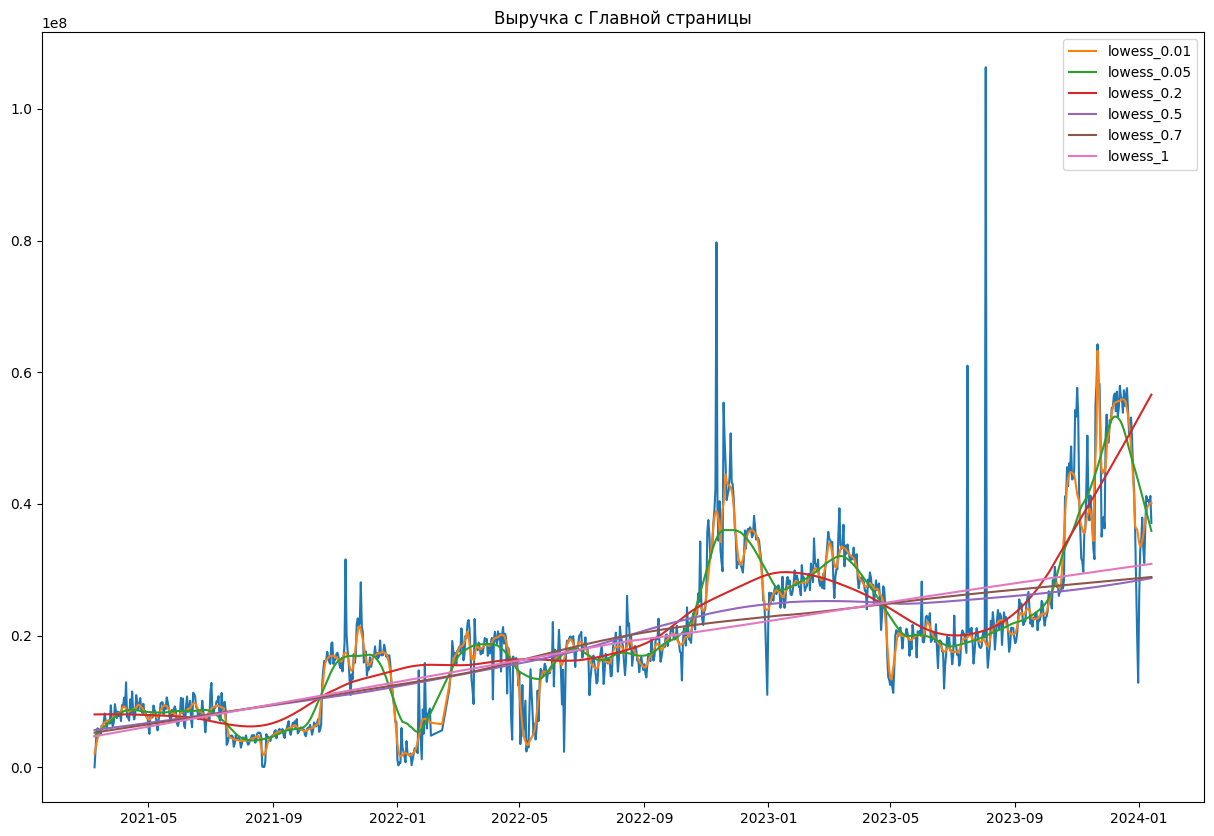

In [324]:
plt.rcParams["figure.figsize"] = (15,10)

plt.figure
plt.plot(d.ds, d.y)
for frac in (0.01, 0.05, 0.2, 0.5, 0.7, 1):
    plt.plot(d.ds, d[f"y_lowess_{frac}"], label = f"lowess_{frac}")
plt.legend()
plt.title("Выручка с Главной страницы")
plt.show()

## AR model

In [325]:
from statsmodels.tsa.ar_model import AutoReg

In [326]:
d = d[["ds", "y"]]
d["y-1"] = d["y"].shift(1)
d["1 diff"] = d["y"] - d["y-1"]
d

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_47942/195472203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["y-1"] = d["y"].shift(1)
/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_47942/195472203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["1 diff"] = d["y"] - d["y-1"]


,ds,y,y-1,1 diff
ds,,,,
2021-03-09,2021-03-09,1.440000e+02,NaN,NaN
2021-03-10,2021-03-10,2.858725e+06,1.440000e+02,2.858581e+06
2021-03-11,2021-03-11,5.511104e+06,2.858725e+06,2.652379e+06
2021-03-12,2021-03-12,5.927380e+06,5.511104e+06,4.162765e+05
2021-03-13,2021-03-13,5.042469e+06,5.927380e+06,-8.849113e+05
...,...,...,...,...
2024-01-09,2024-01-09,4.052303e+07,4.118670e+07,-6.636710e+05
2024-01-10,2024-01-10,4.055967e+07,4.052303e+07,3.664131e+04
2024-01-11,2024-01-11,4.001305e+07,4.055967e+07,-5.466181e+05


<Axes: xlabel='ds'>

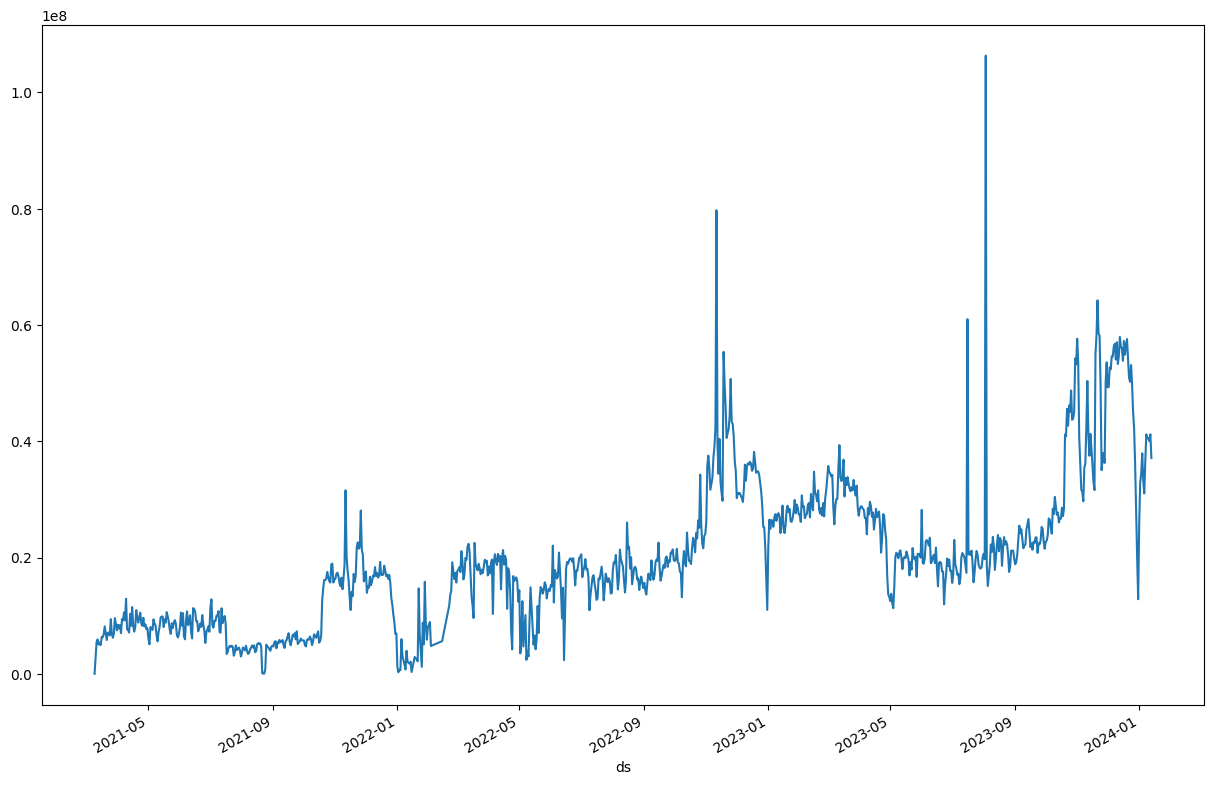

In [327]:
d.y.plot()

<Axes: xlabel='ds'>

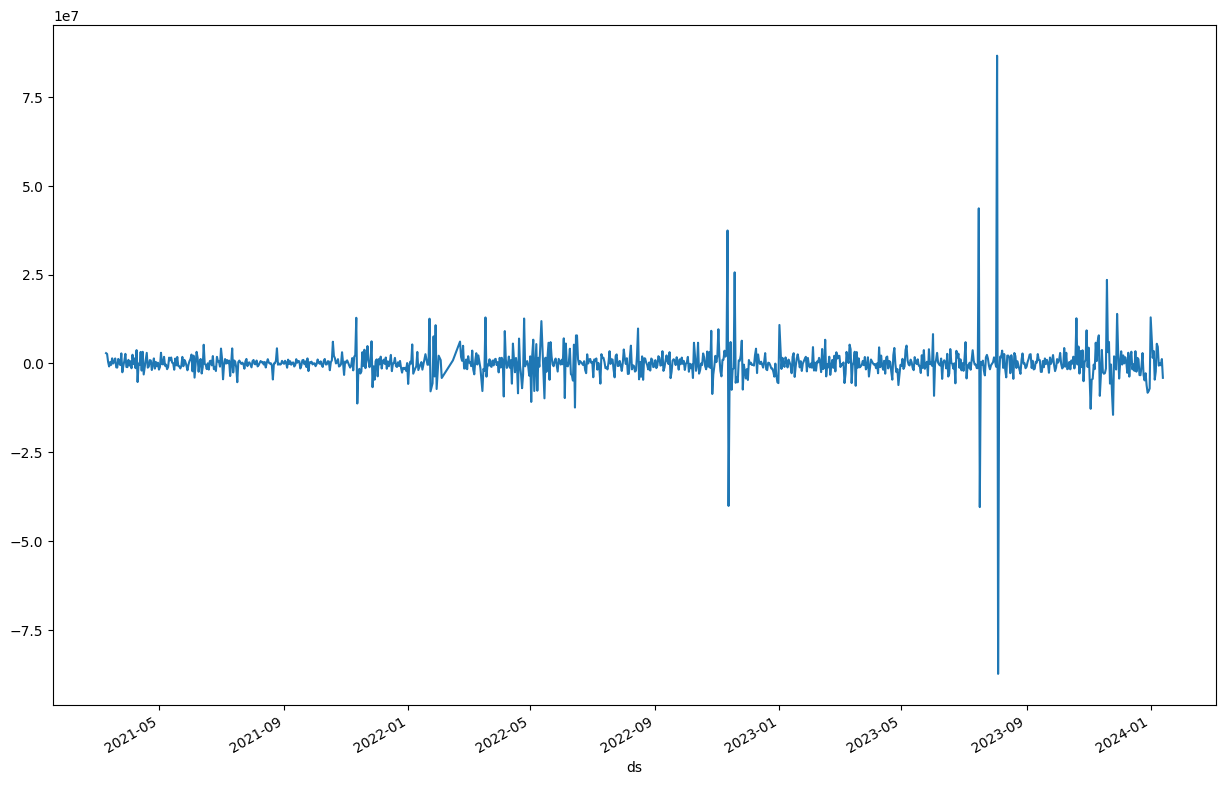

In [328]:
d["1 diff"].plot()

## ARIMA model

In [329]:
from statsmodels.tsa.arima.model import ARIMA

In [330]:
mod = ARIMA(endog = d.y, order = (1, 1, 1))
mod_2 = ARIMA(endog = d.y, order = (2, 1, 1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

In [331]:
res = mod.fit()
res_2 = mod_2.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1012
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -17026.788
Date:                Sun, 28 Jan 2024   AIC                          34059.576
Time:                        14:51:39   BIC                          34074.332
Sample:                             0   HQIC                         34065.181
                               - 1012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2743      0.023     11.774      0.000       0.229       0.320
ma.L1         -0.7797      0.022    -35.602      0.000      -0.823      -0.737
sigma2        2.6e+13   4.79e-16   5.42e+28      0.0

In [332]:
model_y = res.predict(start = "2021-03-09", end = "2024-01-13")
model_y_2 = res_2.predict(start = "2021-03-09", end = "2024-01-13")

In [333]:
d["model_y"] = model_y
d["model_y_2"] = model_y_2

/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_47942/3313723224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["model_y"] = model_y
/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_47942/3313723224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["model_y_2"] = model_y_2


In [334]:
d

,ds,y,y-1,1 diff,model_y,model_y_2
ds,,,,,,
2021-03-09,2021-03-09,1.440000e+02,NaN,NaN,0.000000e+00,0.000000e+00
2021-03-10,2021-03-10,2.858725e+06,1.440000e+02,2.858581e+06,9.552198e+01,9.098187e+01
2021-03-11,2021-03-11,5.511104e+06,2.858725e+06,2.652379e+06,1.673104e+06,1.604303e+06
2021-03-12,2021-03-12,5.927380e+06,5.511104e+06,4.162765e+05,3.443684e+06,3.535479e+06
2021-03-13,2021-03-13,5.042469e+06,5.927380e+06,-8.849113e+05,4.179709e+06,4.375963e+06
...,...,...,...,...,...,...
2024-01-09,2024-01-09,4.052303e+07,4.118670e+07,-6.636710e+05,3.732949e+07,3.781294e+07
2024-01-10,2024-01-10,4.055967e+07,4.052303e+07,3.664131e+04,3.785089e+07,3.845734e+07
2024-01-11,2024-01-11,4.001305e+07,4.055967e+07,-5.466181e+05,3.845761e+07,3.876892e+07


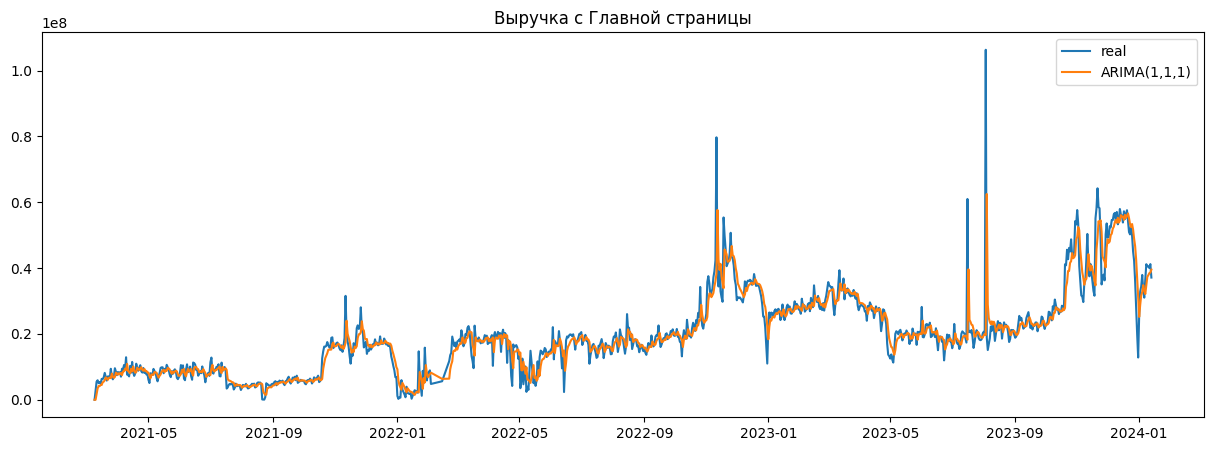

In [336]:
plt.rcParams["figure.figsize"] = (15,5)

plt.figure
plt.plot(d.ds, d.y, label = "real")
plt.plot(d.ds, d.model_y, label = "ARIMA(1,1,1)")
#plt.plot(d.ds, d.model_y_2, label = "ARIMA(2,1,1)")

plt.legend()
plt.title("Выручка с Главной страницы")
plt.show()

In [337]:
res.forecast(120)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1012    3.788652e+07
1013    3.809675e+07
1014    3.815442e+07
1015    3.817024e+07
1016    3.817458e+07
            ...     
1127    3.817622e+07
1128    3.817622e+07
1129    3.817622e+07
1130    3.817622e+07
1131    3.817622e+07
Name: predicted_mean, Length: 120, dtype: float64

In [338]:
import pmdarima

In [339]:
pmdarima.auto_arima(d.y)

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [340]:
mod_auto = ARIMA(endog = d.y, order = (1, 1, 2))
res_auto_arima = mod_auto.fit()
model_y_auto = res_auto_arima.predict(start = "2021-03-09", end = "2024-01-13")
d["model_y_auto"] = model_y_auto

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/23/sf6t2ln1289d0spv6qp4gvbw0000gn/T/ipykernel_47942/2400603842.py:4: SettingWithCopyWarning: 
A value is trying to be

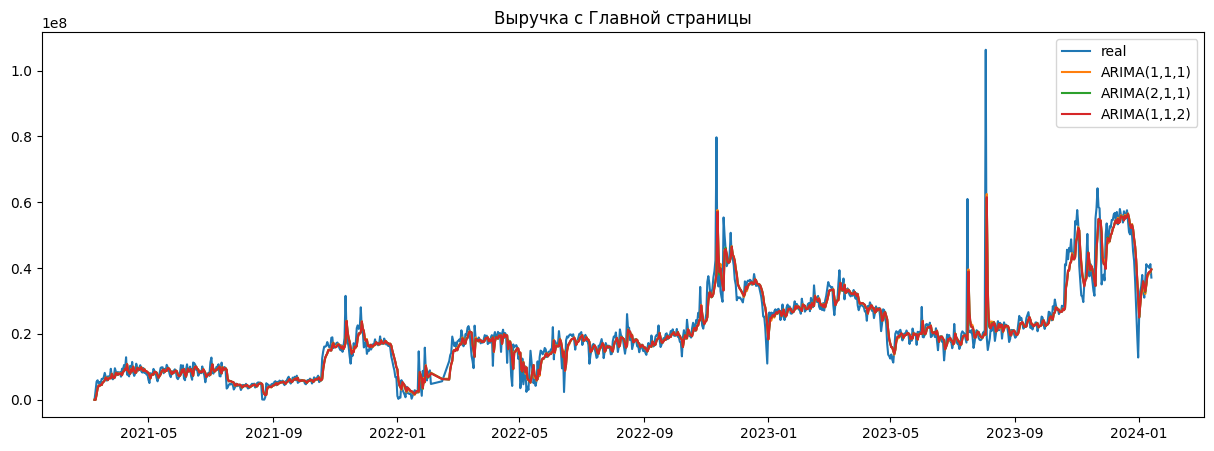

In [341]:
plt.rcParams["figure.figsize"] = (15,5)

plt.figure
plt.plot(d.ds, d.y, label = "real")
plt.plot(d.ds, d.model_y, label = "ARIMA(1,1,1)")
plt.plot(d.ds, d.model_y_2, label = "ARIMA(2,1,1)")
plt.plot(d.ds, d.model_y_auto, label = "ARIMA(1,1,2)")



plt.legend()
plt.title("Выручка с Главной страницы")
plt.show()

In [281]:
from statsmodels.graphics.tsaplots import plot_predict

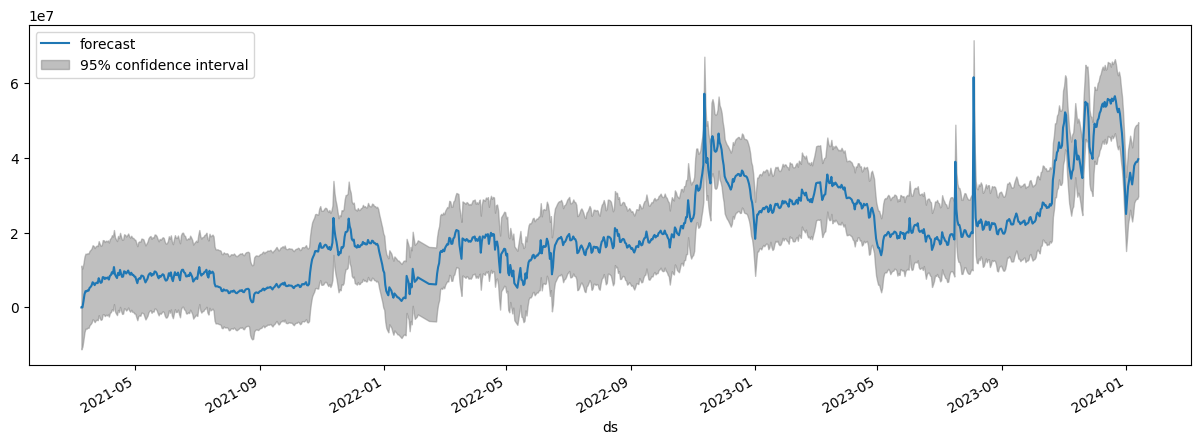

In [282]:
plot_predict(res_auto_arima, "2021-03-09", "2024-01-13")
plt.show()

## Prophet model

In [283]:
d = d[["ds", "y"]].rename(columns = {"ds":"ds_1"}).reset_index()
d = d[["ds", "y"]]
d

,ds,y
0,2021-03-09,1.440000e+02
1,2021-03-10,2.858725e+06
2,2021-03-11,5.511104e+06
3,2021-03-12,5.927380e+06
4,2021-03-13,5.042469e+06
...,...,...
1007,2024-01-09,4.052303e+07
1008,2024-01-10,4.055967e+07
1009,2024-01-11,4.001305e+07
1010,2024-01-12,4.120578e+07


In [342]:
# Setting holidays 

black_fridays = pd.DataFrame({
  'holiday': 'black_friday',
  'ds': pd.to_datetime(['2022-11-26', '2022-11-25', '2023-11-24',]),
  'lower_window': -14,
  'upper_window': 14,
})
new_years = pd.DataFrame({
  'holiday': 'new_year',
  'ds': pd.to_datetime(['2021-12-31', '2022-12-31', '2023-12-31']),
  'lower_window': -2,
  'upper_window': 7,
})
febs_23 = pd.DataFrame({
  'holiday': '23_feb',
  'ds': pd.to_datetime(['2021-02-23', '2022-02-23', '2023-02-23']),
  'lower_window': -4,
  'upper_window': 3,
})

mays_1 = pd.DataFrame({
  'holiday': '1_may',
  'ds': pd.to_datetime(['2021-05-01', '2022-05-01', '2023-05-01']),
  'lower_window': -2,
  'upper_window': 2,
})


holidays = pd.concat((black_fridays, new_years, febs_23, mays_1))
holidays

,holiday,ds,lower_window,upper_window
0,black_friday,2022-11-26,-14,14
1,black_friday,2022-11-25,-14,14
2,black_friday,2023-11-24,-14,14
0,new_year,2021-12-31,-2,7
1,new_year,2022-12-31,-2,7
2,new_year,2023-12-31,-2,7
0,23_feb,2021-02-23,-4,3
1,23_feb,2022-02-23,-4,3
2,23_feb,2023-02-23,-4,3
0,1_may,2021-05-01,-2,2


In [343]:
# Setting Baseline Prophet model
model = Prophet(yearly_seasonality=7, 
            weekly_seasonality=10, 
            holidays=holidays, 
            growth = "linear", 
            holidays_prior_scale = 10,
            n_changepoints = 20,)
model.fit(d)

15:07:40 - cmdstanpy - INFO - Chain [1] start processing
15:07:40 - cmdstanpy - INFO - Chain [1] done processing


In [344]:
# Creating Future Dataset for Forecasting 
future = model.make_future_dataframe(periods=50)
future.tail()

,ds
1057,2024-02-28
1058,2024-02-29
1059,2024-03-01
1060,2024-03-02
1061,2024-03-03


In [345]:
forecast = model.predict(future)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


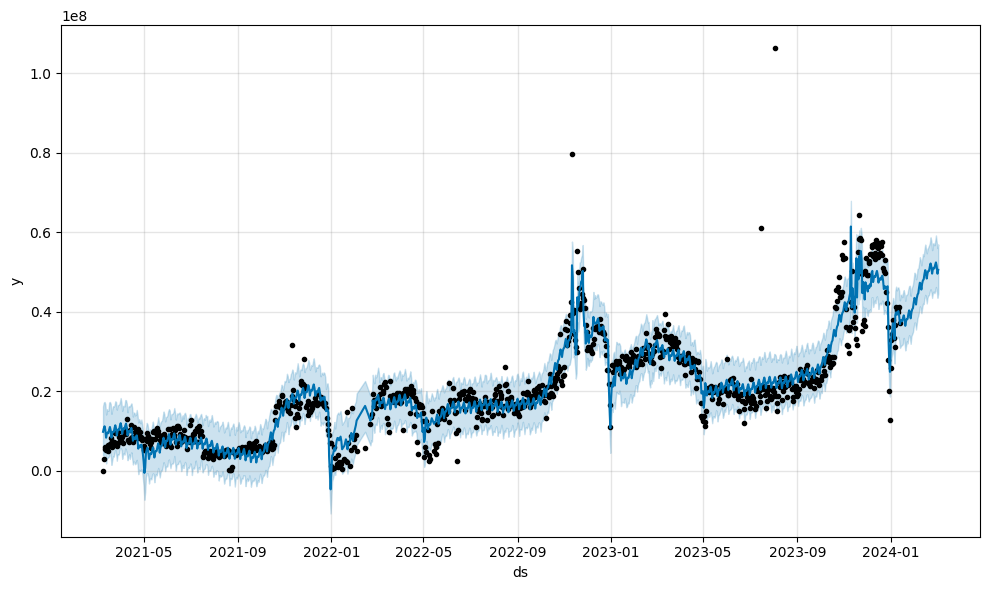

In [346]:
predict_plot = model.plot(forecast)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

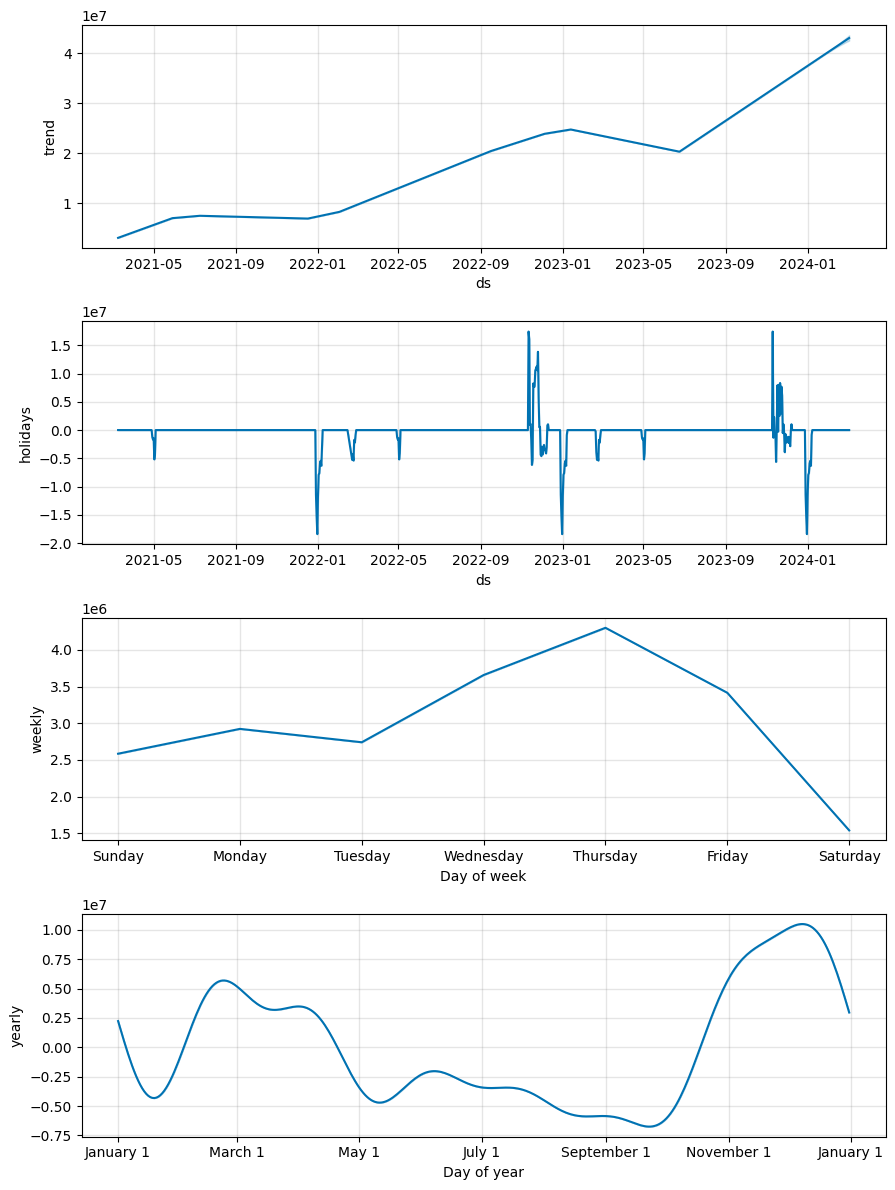

In [289]:
components_plot = model.plot_components(forecast)

In [290]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1_may,1_may_lower,1_may_upper,23_feb,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-09,3.015207e+06,3.624690e+06,1.587684e+07,3.015207e+06,3.015207e+06,0.0,0.0,0.0,0.0,...,2.741309e+06,2.741309e+06,2.741309e+06,3.995216e+06,3.995216e+06,3.995216e+06,0.0,0.0,0.0,9.751733e+06
1,2021-03-10,3.063969e+06,4.217951e+06,1.651841e+07,3.063969e+06,3.063969e+06,0.0,0.0,0.0,0.0,...,3.657369e+06,3.657369e+06,3.657369e+06,3.857932e+06,3.857932e+06,3.857932e+06,0.0,0.0,0.0,1.057927e+07
2,2021-03-11,3.112730e+06,5.035006e+06,1.723503e+07,3.112730e+06,3.112730e+06,0.0,0.0,0.0,0.0,...,4.300748e+06,4.300748e+06,4.300748e+06,3.730838e+06,3.730838e+06,3.730838e+06,0.0,0.0,0.0,1.114432e+07
3,2021-03-12,3.161491e+06,3.484842e+06,1.679851e+07,3.161491e+06,3.161491e+06,0.0,0.0,0.0,0.0,...,3.415362e+06,3.415362e+06,3.415362e+06,3.615402e+06,3.615402e+06,3.615402e+06,0.0,0.0,0.0,1.019226e+07
4,2021-03-13,3.210252e+06,2.213362e+06,1.436138e+07,3.210252e+06,3.210252e+06,0.0,0.0,0.0,0.0,...,1.541466e+06,1.541466e+06,1.541466e+06,3.512807e+06,3.512807e+06,3.512807e+06,0.0,0.0,0.0,8.264525e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,2024-02-28,4.272438e+07,4.540540e+07,5.790895e+07,4.231881e+07,4.318660e+07,0.0,0.0,0.0,0.0,...,3.657369e+06,3.657369e+06,3.657369e+06,5.417841e+06,5.417841e+06,5.417841e+06,0.0,0.0,0.0,5.179959e+07
1058,2024-02-29,4.281447e+07,4.588092e+07,5.872347e+07,4.238143e+07,4.329139e+07,0.0,0.0,0.0,0.0,...,4.300748e+06,4.300748e+06,4.300748e+06,5.302049e+06,5.302049e+06,5.302049e+06,0.0,0.0,0.0,5.241726e+07
1059,2024-03-01,4.290455e+07,4.465413e+07,5.758980e+07,4.244635e+07,4.339651e+07,0.0,0.0,0.0,0.0,...,3.415362e+06,3.415362e+06,3.415362e+06,5.172126e+06,5.172126e+06,5.172126e+06,0.0,0.0,0.0,5.149204e+07
1060,2024-03-02,4.299463e+07,4.318183e+07,5.565268e+07,4.251106e+07,4.351862e+07,0.0,0.0,0.0,0.0,...,1.541466e+06,1.541466e+06,1.541466e+06,5.030926e+06,5.030926e+06,5.030926e+06,0.0,0.0,0.0,4.956702e+07


In [291]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2021-03-09,9.751733e+06,3.624690e+06,1.587684e+07
1,2021-03-10,1.057927e+07,4.217951e+06,1.651841e+07
2,2021-03-11,1.114432e+07,5.035006e+06,1.723503e+07
3,2021-03-12,1.019226e+07,3.484842e+06,1.679851e+07
4,2021-03-13,8.264525e+06,2.213362e+06,1.436138e+07
...,...,...,...,...
1057,2024-02-28,5.179959e+07,4.540540e+07,5.790895e+07
1058,2024-02-29,5.241726e+07,4.588092e+07,5.872347e+07
1059,2024-03-01,5.149204e+07,4.465413e+07,5.758980e+07
1060,2024-03-02,4.956702e+07,4.318183e+07,5.565268e+07


In [292]:
d.reset_index(inplace = True)

In [293]:
df = pd.merge(d, forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], how = "right", on = "ds")

In [294]:
df

,index,ds,y,yhat,yhat_lower,yhat_upper
0,0.0,2021-03-09,1.440000e+02,9.751733e+06,3.624690e+06,1.587684e+07
1,1.0,2021-03-10,2.858725e+06,1.057927e+07,4.217951e+06,1.651841e+07
2,2.0,2021-03-11,5.511104e+06,1.114432e+07,5.035006e+06,1.723503e+07
3,3.0,2021-03-12,5.927380e+06,1.019226e+07,3.484842e+06,1.679851e+07
4,4.0,2021-03-13,5.042469e+06,8.264525e+06,2.213362e+06,1.436138e+07
...,...,...,...,...,...,...
1057,NaN,2024-02-28,NaN,5.179959e+07,4.540540e+07,5.790895e+07
1058,NaN,2024-02-29,NaN,5.241726e+07,4.588092e+07,5.872347e+07
1059,NaN,2024-03-01,NaN,5.149204e+07,4.465413e+07,5.758980e+07
1060,NaN,2024-03-02,NaN,4.956702e+07,4.318183e+07,5.565268e+07


In [295]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

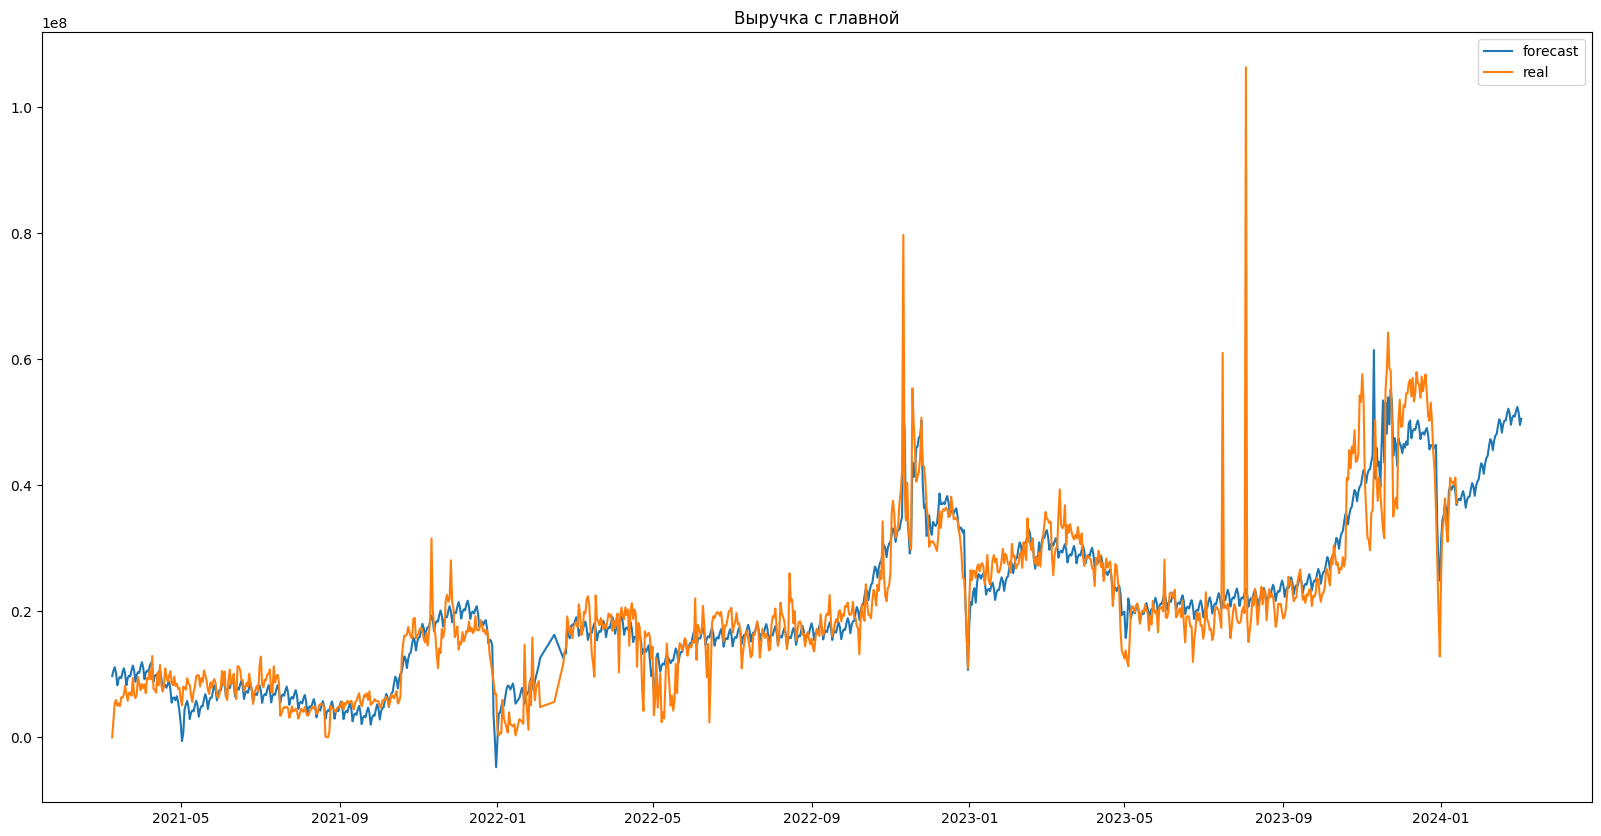

In [296]:
plt.figure()
plt.plot(df.ds, df.yhat, label = "forecast", ls = "-")
plt.plot(df.ds, df.y, label = "real")
plt.title("Выручка с главной")
plt.legend()
plt.show()